Load libraries

In [51]:
# Import necessary libraries
import pandas as pd # for data processing
import numpy as np # here mostly for series generation

import matplotlib.pyplot as plt # for vizualization
import matplotlib.dates as mdates # for data formatting when visualizing
import matplotlib.ticker as ticker # for more advanced axis formatting

import seaborn as sns


import statsmodels.api as sm # for linear regression model, OLS estimation
import statsmodels.stats.diagnostic as smd # for Breusch-Godfrey test

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR, VECM
from statsmodels.api import OLS
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # ACF, PACF plots
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.vector_ar.vecm import select_order, select_coint_rank, coint_johansen
from statsmodels.stats.stattools import jarque_bera

from scipy.stats import norm

from IPython.display import Markdown

import yfinance as yf # for importing data directly from finance.yahoo.com

import warnings
warnings.simplefilter("ignore", category="UserWarning")
warnings.simplefilter("ignore", category="ValueWarning")

# Set global options
pd.options.display.float_format = '{:.10f}'.format
sns.set_theme(style="whitegrid")

# Set plotting style
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
warnings.filterwarnings("ignore")

## 0. Data preparation and pair selection

We import the dataset and set date column as the index

In [52]:
# Adjust path relative to the notebook location
file_path = 'data/TSA_2025_project_data_1.csv'
df = pd.read_csv(file_path)
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

Lets create our in-sample (first 575 periods) and out-of-sample (rest periods of the df) splits of the original data.

In [53]:
train_df = df.iloc[:575]
test_df = df.iloc[575:]

In [54]:
print(df.columns)

Index(['y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7', 'y8', 'y9', 'y10'], dtype='object')


Lets plot all the variables and try to observe which pair seems to move together

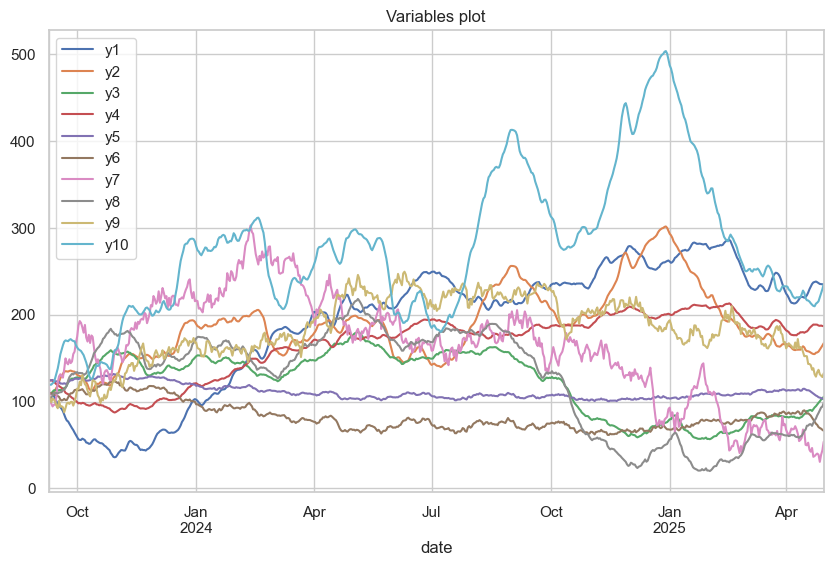

In [55]:
df[['y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7', 'y8', 'y9', 'y10']].plot(figsize=(10, 6), title="Variables plot")
plt.show()

With no test yet we can appreciete a similar tendency on the variables [y2 and y10], [y3 and y8] and [y5 and y6] 

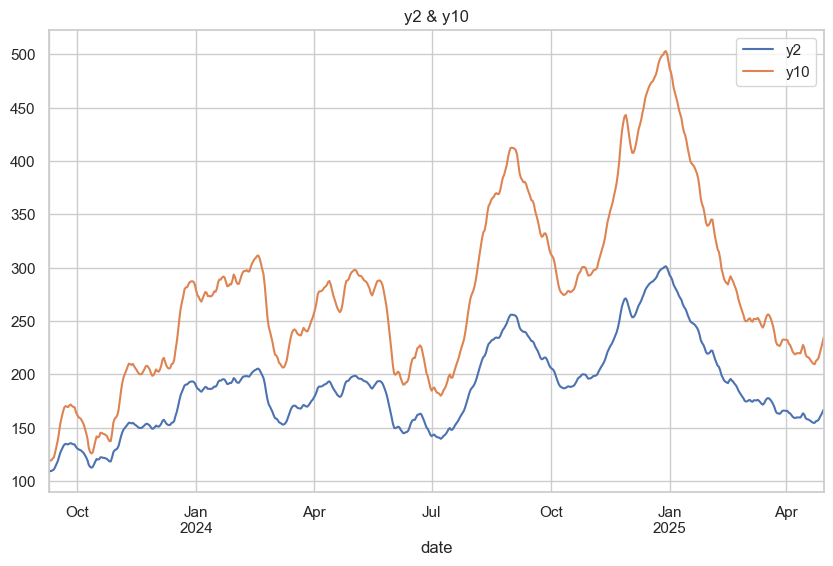

In [56]:
df[['y2','y10']].plot(figsize=(10, 6), title="y2 & y10")
plt.show()

Variables **y2** and **y10** aparently seems to be cointegrated in the plot, so we will start testing for cointegration with this pair.

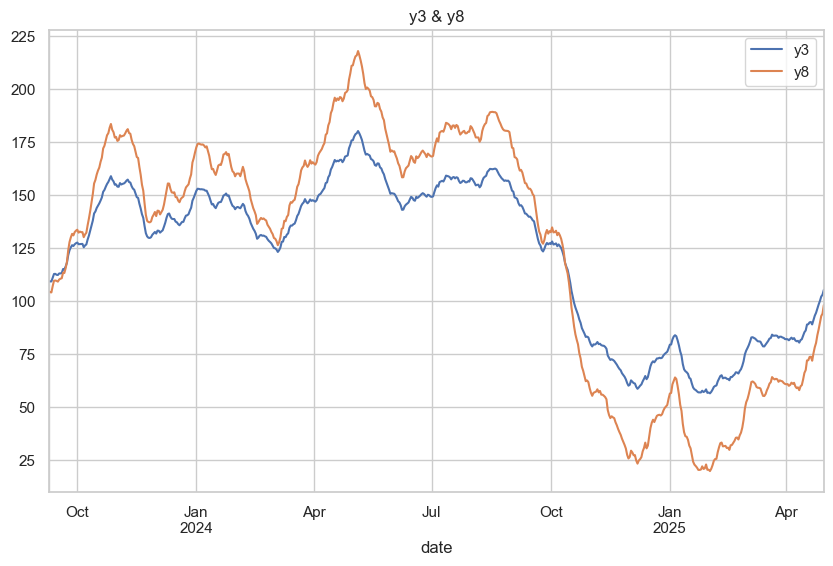

In [57]:
df[['y3', 'y8']].plot(figsize=(10, 6), title="y3 & y8")
plt.show()

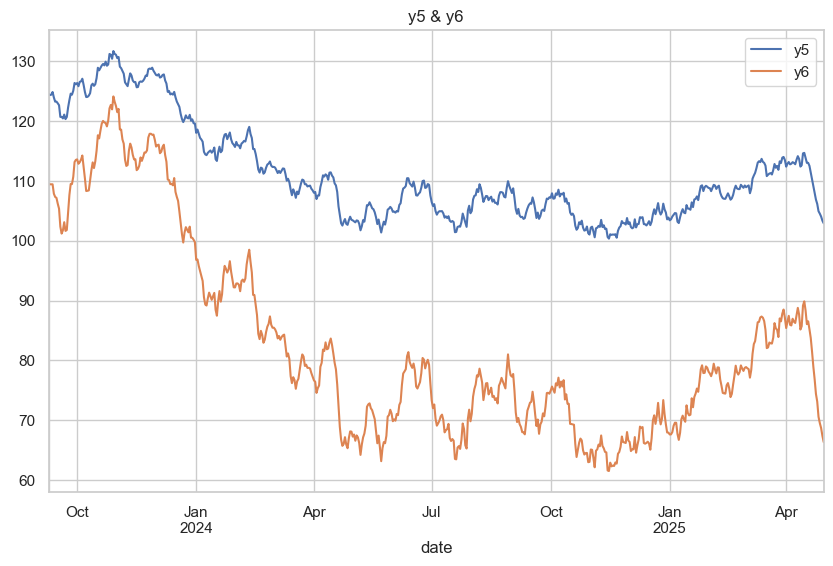

In [58]:
df[['y5', 'y6']].plot(figsize=(10, 6), title="y5 & y6")
plt.show()

Lets create the differences of our variables for our cointegration test

In [59]:
diff_df = train_df[['y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7', 'y8', 'y9', 'y10']].diff()

for col in diff_df.columns:
    train_df[f'd{col}'] = diff_df[col]

## 1. Engle-Granger Two-Step Cointegration Test

This section applies the Engle-Granger two-step procedure to examine whether two non-stationary time series are cointegrated.

---

1. **Checking Integration Order (ADF Test)**  
   We begin by testing each time series individually using the Augmented Dickey-Fuller (ADF) test. This helps determine whether the series are integrated of order 1 ($I(1)$), meaning they exhibit non-stationarity in levels but become stationary after first differencing. Establishing this property is a necessary condition for cointegration.

2. **Estimating Long-Run Relationship and Testing Residuals**  
   Once both series are confirmed to be I(1), we estimate a long-run equilibrium relationship between them using an Ordinary Least Squares (OLS) regression:

   $$
   y_t = \alpha + \beta x_t + u_t
   $$

   The residuals $ \hat{u}_t $ from this regression represent deviations from this long-term relationship. To check whether these deviations are stationary, we apply the ADF test once again but this time to the residuals.  

   - If the residuals are stationary, this indicates that the two series move together over time and are **cointegrated**.
   - If the residuals are non-stationary, we conclude that no cointegration is present.




### 1.1. First step: Integration order

In [60]:
def adf_test(series, max_lag=5):
    result = adfuller(series.dropna(), maxlag=max_lag, autolag=None)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if result[0] < result[4]["5%"]:
        print ("Reject Ho - Time Series is Stationary")
    else:
        print ("Failed to Reject Ho - Time Series is Non-Stationary")

In [61]:
X = train_df["y2"].values
adf_test(df["y2"])

ADF Statistic: -2.384781
p-value: 0.146078
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569
Failed to Reject Ho - Time Series is Non-Stationary


In [62]:
X = train_df["y10"].values
adf_test(train_df["y10"])

ADF Statistic: -2.250023
p-value: 0.188593
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.569
Failed to Reject Ho - Time Series is Non-Stationary


Since both variables fail to reject the null hypothesis, they appear to be non-stationary in levels. Therefore, we move on to test their first differences.

In [63]:
X = train_df["dy2"].values
adf_test(train_df["dy2"])

ADF Statistic: -6.574744
p-value: 0.000000
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.569
Reject Ho - Time Series is Stationary


In [64]:
X = train_df["dy10"].values
adf_test(train_df["dy10"])

ADF Statistic: -6.511367
p-value: 0.000000
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.569
Reject Ho - Time Series is Stationary


After first differencing, both variables appear stationary, suggesting they are  $\sim I(1)$.

Before checking for stationarity on the residuals lets check the number of augmentation needed for stationarity

In [65]:
def adf_test(series, max_aug=10, version='c'):
    
    results = []

    y = series.diff()
    X = pd.DataFrame({'y_lag': series.shift()})

    if version == 'c' or version == 't': # constant to be added optionally 
        X = sm.add_constant(X)
    if version == 't': # (deterministic) trend component to be added optionally
        X['trend'] = range(len(X))

    for i in range(0, max_aug): # iterating through different numbers of augmentations
        
        for aug in range(1, i+1): # adding augmentations max_aug is reached
            X['aug_'+str(aug)] = y.shift(aug)

        model = sm.OLS(series.diff(), X, missing='drop').fit() # fitting a linear regression with OLS

        ts = model.tvalues['y_lag'] # test statistic
        nobs = model.nobs # number of observations

        if version == 'n': # critical values for basic version of ADF
            if nobs > 100:
                cv01 = -2.567; cv05 = -1.941; cv10 = -1.616 # critical values for more than 500 observations
            else:
                cv01 = np.nan; cv05 = np.nan; cv10 = np.nan # if number of observations is lower than 500, we should check the critical values manually
        if version == 'c': # critical values for version with constant
            if nobs > 100:
                cv01 = -3.434; cv05 = -2.863; cv10 = -2.568 # critical values for more than 500 observations
            else:
                cv01 = np.nan; cv05 = np.nan; cv10 = np.nan # if number of observations is lower than 500, we should check the critical values manually
        if version == 't': # critical values for version with constant and (deterministic) trend component
            if nobs > 100:
                cv01 = -3.963; cv05 = -3.413; cv10 = -3.128 # critical values for more than 500 observations
            else:
                cv01 = np.nan; cv05 = np.nan; cv10 = np.nan # if number of observations is lower than 500, we should check the critical values manually

        bg_test01 = smd.acorr_breusch_godfrey(model, nlags=1);  bg_pvalue01 = round(bg_test01[1],4); bg_test01 = round(bg_test01[0],4); 
        bg_test05 = smd.acorr_breusch_godfrey(model, nlags=5);  bg_pvalue05 = round(bg_test05[1],4); bg_test05 = round(bg_test05[0],4); 
        bg_test10 = smd.acorr_breusch_godfrey(model, nlags=10); bg_pvalue10 = round(bg_test10[1],4); bg_test10 = round(bg_test10[0],4);
        bg_test15 = smd.acorr_breusch_godfrey(model, nlags=15); bg_pvalue15 = round(bg_test15[1],4); bg_test15 = round(bg_test15[0],4);

        results.append([i, ts, cv01, cv05, cv10, 
                        bg_test01, bg_pvalue01, bg_test05, bg_pvalue05, bg_test10, bg_pvalue10, bg_test15, bg_pvalue15])

    results_df = pd.DataFrame(results)
    results_df.columns = ['number of augmentations', 
                          'ADF test statistic', 'ADF critival value (1%)', 'ADF critival value (5%)', 'ADF critival value (10%)', 
                          'BG test (1 lag) (statistic)', 'BG test (1 lag) (p-value)', 
                          'BG test (5 lags) (statistic)', 'BG test (5 lags) (p-value)', 
                          'BG test (10 lags) (statistic)', 'BG test (10 lags) (p-value)', 
                          'BG test (15 lags) (statistic)', 'BG test (15 lags) (p-value)']
    
    return results_df

In [66]:
adf_test(train_df['y2'])

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-1.8822597171,-3.4340000000,-2.8630000000,-2.5680000000,425.7181000000,0.0000000000,449.7069000000,0.0000000000,452.5615000000,0.0000000000,453.1616000000,0.0000000000
1,1,-2.6157603140,-3.4340000000,-2.8630000000,-2.5680000000,47.3642000000,0.0000000000,97.9047000000,0.0000000000,102.8077000000,0.0000000000,104.6629000000,0.0000000000
2,2,-2.1496364941,-3.4340000000,-2.8630000000,-2.5680000000,26.6086000000,0.0000000000,57.3745000000,0.0000000000,60.4578000000,0.0000000000,62.2334000000,0.0000000000
3,3,-2.4049360991,-3.4340000000,-2.8630000000,-2.5680000000,12.3845000000,0.0004000000,33.3642000000,0.0000000000,38.7658000000,0.0000000000,40.0410000000,0.0004000000
4,4,-2.1935056626,-3.4340000000,-2.8630000000,-2.5680000000,12.8349000000,0.0003000000,25.2678000000,0.0001000000,30.1459000000,0.0008000000,31.6027000000,0.0073000000
5,5,-2.2673831114,-3.4340000000,-2.8630000000,-2.5680000000,5.9263000000,0.0149000000,12.6567000000,0.0268000000,16.7567000000,0.0799000000,17.6630000000,0.2808000000
6,6,-2.0950562734,-3.4340000000,-2.8630000000,-2.5680000000,2.4646000000,0.1164000000,3.1010000000,0.6844000000,8.1404000000,0.6151000000,9.6346000000,0.8421000000
7,7,-2.1268162270,-3.4340000000,-2.8630000000,-2.5680000000,0.0088000000,0.9254000000,4.4085000000,0.4922000000,6.5432000000,0.7677000000,8.2050000000,0.9153000000
8,8,-2.0161896703,-3.4340000000,-2.8630000000,-2.5680000000,0.0003000000,0.9869000000,0.2940000000,0.9978000000,8.5821000000,0.5722000000,10.2659000000,0.8027000000
9,9,-2.0628662544,-3.4340000000,-2.8630000000,-2.5680000000,0.7748000000,0.3787000000,4.3188000000,0.5045000000,6.0732000000,0.8091000000,9.5162000000,0.8490000000


In [67]:
adf_test(train_df['y10'])

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-1.8841970367,-3.4340000000,-2.8630000000,-2.5680000000,424.8320000000,0.0000000000,446.6175000000,0.0000000000,448.9251000000,0.0000000000,449.7937000000,0.0000000000
1,1,-2.6105197595,-3.4340000000,-2.8630000000,-2.5680000000,44.9137000000,0.0000000000,87.3367000000,0.0000000000,91.9624000000,0.0000000000,94.8094000000,0.0000000000
2,2,-2.1572125995,-3.4340000000,-2.8630000000,-2.5680000000,23.4591000000,0.0000000000,47.4175000000,0.0000000000,51.3834000000,0.0000000000,54.0694000000,0.0000000000
3,3,-2.3880321292,-3.4340000000,-2.8630000000,-2.5680000000,10.0651000000,0.0015000000,26.0485000000,0.0001000000,33.1850000000,0.0003000000,35.2355000000,0.0023000000
4,4,-2.2158434286,-3.4340000000,-2.8630000000,-2.5680000000,11.4985000000,0.0007000000,20.5542000000,0.0010000000,27.1344000000,0.0025000000,29.5367000000,0.0137000000
5,5,-2.2500225144,-3.4340000000,-2.8630000000,-2.5680000000,4.5137000000,0.0336000000,9.3863000000,0.0946000000,14.2728000000,0.1609000000,16.4127000000,0.3552000000
6,6,-2.1211851993,-3.4340000000,-2.8630000000,-2.5680000000,1.4136000000,0.2345000000,2.0948000000,0.8359000000,8.5889000000,0.5715000000,11.1112000000,0.7447000000
7,7,-2.1000681212,-3.4340000000,-2.8630000000,-2.5680000000,0.2525000000,0.6153000000,4.1009000000,0.5350000000,8.0809000000,0.6209000000,11.1190000000,0.7441000000
8,8,-2.0400696030,-3.4340000000,-2.8630000000,-2.5680000000,0.7993000000,0.3713000000,1.5940000000,0.9020000000,9.9952000000,0.4409000000,13.3483000000,0.5754000000
9,9,-2.0439985379,-3.4340000000,-2.8630000000,-2.5680000000,0.3369000000,0.5616000000,4.3649000000,0.4982000000,7.0440000000,0.7213000000,12.7791000000,0.6194000000


In [68]:
adf_test(train_df['dy2'])

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-6.5264261015,-3.4340000000,-2.8630000000,-2.5680000000,49.4347000000,0.0000000000,99.4710000000,0.0000000000,103.8406000000,0.0000000000,105.6099000000,0.0000000000
1,1,-8.5108319450,-3.4340000000,-2.8630000000,-2.5680000000,25.1371000000,0.0000000000,56.5251000000,0.0000000000,60.2453000000,0.0000000000,61.8927000000,0.0000000000
2,2,-6.4547703190,-3.4340000000,-2.8630000000,-2.5680000000,13.2432000000,0.0003000000,34.6242000000,0.0000000000,39.2896000000,0.0000000000,40.3723000000,0.0004000000
3,3,-7.2512492577,-3.4340000000,-2.8630000000,-2.5680000000,11.4218000000,0.0007000000,22.4273000000,0.0004000000,28.7420000000,0.0014000000,31.1664000000,0.0083000000
4,4,-6.0530363178,-3.4340000000,-2.8630000000,-2.5680000000,5.8534000000,0.0155000000,13.4716000000,0.0193000000,16.9595000000,0.0753000000,17.6737000000,0.2802000000
5,5,-6.5747441997,-3.4340000000,-2.8630000000,-2.5680000000,1.9583000000,0.1617000000,3.0217000000,0.6966000000,7.6603000000,0.6620000000,8.9673000000,0.8792000000
6,6,-5.9884128035,-3.4340000000,-2.8630000000,-2.5680000000,0.0331000000,0.8557000000,4.5996000000,0.4667000000,6.3734000000,0.7830000000,7.6892000000,0.9356000000
7,7,-5.9705493783,-3.4340000000,-2.8630000000,-2.5680000000,0.0100000000,0.9202000000,0.2143000000,0.9990000000,7.7447000000,0.6538000000,9.3393000000,0.8591000000
8,8,-5.5150496553,-3.4340000000,-2.8630000000,-2.5680000000,0.3905000000,0.5320000000,4.0894000000,0.5366000000,5.3505000000,0.8666000000,8.0173000000,0.9231000000
9,9,-5.0597388737,-3.4340000000,-2.8630000000,-2.5680000000,0.8463000000,0.3576000000,2.4249000000,0.7878000000,4.0264000000,0.9461000000,6.0733000000,0.9785000000


In [69]:
adf_test(train_df['dy10'])

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-6.5498339355,-3.4340000000,-2.8630000000,-2.5680000000,46.9409000000,0.0000000000,88.8667000000,0.0000000000,92.9935000000,0.0000000000,95.7079000000,0.0000000000
1,1,-8.4691134007,-3.4340000000,-2.8630000000,-2.5680000000,22.0677000000,0.0000000000,46.3786000000,0.0000000000,51.0895000000,0.0000000000,53.4932000000,0.0000000000
2,2,-6.5175642444,-3.4340000000,-2.8630000000,-2.5680000000,10.8611000000,0.0010000000,27.2425000000,0.0001000000,33.6782000000,0.0002000000,35.5019000000,0.0021000000
3,3,-7.2005973366,-3.4340000000,-2.8630000000,-2.5680000000,10.1311000000,0.0015000000,19.0368000000,0.0019000000,24.3167000000,0.0068000000,29.3831000000,0.0144000000
4,4,-6.1030210775,-3.4340000000,-2.8630000000,-2.5680000000,4.3882000000,0.0362000000,10.1735000000,0.0705000000,14.5389000000,0.1498000000,16.4982000000,0.3497000000
5,5,-6.5113665233,-3.4340000000,-2.8630000000,-2.5680000000,1.0206000000,0.3124000000,2.1472000000,0.8284000000,8.1432000000,0.6148000000,10.5545000000,0.7835000000
6,6,-6.0714771785,-3.4340000000,-2.8630000000,-2.5680000000,0.3530000000,0.5524000000,4.3293000000,0.5030000000,7.7331000000,0.6549000000,10.3859000000,0.7948000000
7,7,-5.9345210003,-3.4340000000,-2.8630000000,-2.5680000000,0.7358000000,0.3910000000,1.5559000000,0.9065000000,9.2835000000,0.5054000000,12.5279000000,0.6387000000
8,8,-5.5690146782,-3.4340000000,-2.8630000000,-2.5680000000,0.0832000000,0.7730000000,5.0274000000,0.4125000000,5.9377000000,0.8205000000,11.0986000000,0.7456000000
9,9,-5.0118793968,-3.4340000000,-2.8630000000,-2.5680000000,1.5562000000,0.2122000000,3.6003000000,0.6083000000,6.1205000000,0.8050000000,7.4279000000,0.9447000000


Once again we can see that the variables are integrated of order 1, no autocorrelation in residuals from 5 augmentations. Therefore, we can now proceed to test for cointegration.

### 1.2. Second step: Stationarity of residuals

To estimating the cointegrating vector, we will estimate the following model:

In [70]:
model_coint = OLS(train_df['y2'], np.column_stack((np.ones(len(train_df)), train_df['y10']))).fit()
print(model_coint.summary())

                            OLS Regression Results                            
Dep. Variable:                     y2   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.386e+08
Date:                Mon, 26 May 2025   Prob (F-statistic):               0.00
Time:                        22:25:28   Log-Likelihood:                 924.52
No. Observations:                 575   AIC:                            -1845.
Df Residuals:                     573   BIC:                            -1836.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         49.6951      0.007   7134.319      0.0

In [71]:
beta = model_coint.params
print(f"beta.const: {beta.const:.4f}")

beta.const: 49.6951


In [72]:
# Test stationarity of residuals
residuals = model_coint.resid
adf_test(pd.Series(residuals))

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-24.0445796757,-3.4340000000,-2.8630000000,-2.5680000000,0.2826000000,0.5950000000,4.7958000000,0.4413000000,7.1766000000,0.7087000000,14.6780000000,0.4749000000
1,1,-16.2518209716,-3.4340000000,-2.8630000000,-2.5680000000,0.3555000000,0.5510000000,4.4236000000,0.4902000000,6.6004000000,0.7626000000,14.5325000000,0.4856000000
2,2,-13.9834050589,-3.4340000000,-2.8630000000,-2.5680000000,-1.6957000000,1.0000000000,6.2373000000,0.2838000000,9.8001000000,0.4582000000,17.0236000000,0.3175000000
3,3,-12.7346917455,-3.4340000000,-2.8630000000,-2.5680000000,-2.2757000000,1.0000000000,6.8930000000,0.2287000000,9.4135000000,0.4934000000,17.0891000000,0.3136000000
4,4,-11.0323176443,-3.4340000000,-2.8630000000,-2.5680000000,0.0188000000,0.8909000000,3.7726000000,0.5826000000,6.5410000000,0.7679000000,13.7206000000,0.5468000000
5,5,-10.0312739174,-3.4340000000,-2.8630000000,-2.5680000000,0.7200000000,0.3961000000,3.7393000000,0.5875000000,11.0058000000,0.3571000000,18.8154000000,0.2222000000
6,6,-9.0909815580,-3.4340000000,-2.8630000000,-2.5680000000,1.5972000000,0.2063000000,2.9484000000,0.7079000000,10.2575000000,0.4182000000,17.2168000000,0.3061000000
7,7,-8.5232972300,-3.4340000000,-2.8630000000,-2.5680000000,0.2962000000,0.5863000000,6.6141000000,0.2510000000,10.2254000000,0.4209000000,18.1742000000,0.2536000000
8,8,-8.4914186118,-3.4340000000,-2.8630000000,-2.5680000000,-1.0726000000,1.0000000000,4.5319000000,0.4756000000,17.2260000000,0.0695000000,22.4496000000,0.0965000000
9,9,-8.1375389518,-3.4340000000,-2.8630000000,-2.5680000000,0.5711000000,0.4498000000,4.7698000000,0.4446000000,16.5225000000,0.0856000000,18.9631000000,0.2154000000


The null hypothesis of non-stationary residuals is rejected without the need for augmentations, indicating that the residuals are stationary. Therefore, y2 and y10 are cointegrated of order $ I(1) $.

In [73]:
Markdown(f"The cointegrating vector is [1, -{beta.const:.3f}, -{beta.x1:.3f}]. This defines the cointegrating relationship as: 1 * y2 = -{beta.const:.3f} - {beta.x1:.3f} * y10.")

The cointegrating vector is [1, -49.695, -0.500]. This defines the cointegrating relationship as: 1 * y2 = -49.695 - 0.500 * y10.

## 2. Vector Error Correction Model (VECM) estimation and forecast

The VECM is a multivariate time series model designed to capture both the short-term dynamics and the long-term equilibrium relationships among integrated variables. Mathematically, it can be expressed as:

                            
$$\Delta\boldsymbol{y}_t = \Pi\boldsymbol{y}_{t-1} + \Gamma_1\Delta\boldsymbol{y}_{t-1} + ... + \Gamma_p\Delta\boldsymbol{y}_{t-p} + \boldsymbol{c}_d + \boldsymbol{\varepsilon}_t$$


where: 
$$
\boldsymbol{\Pi}=\alpha\beta'=\left[
	\begin{array}{ccc}
	\alpha_{11} \\
	\alpha_{21} \\
	\end{array} 
\right]
\left[
	\begin{array}{cccc}
\beta_{11} \quad \beta_{21} \\
 \end{array}
\right]
$$

 
- $\Delta$ is the first difference operator,  
- $\mathbf{y}_t$ is a vector of integrated variables,   
- $\Pi$ contains information about long-run relationships (cointegration),  
- $\Gamma_i$ captures short-run dynamics,  
- $\mathbf{c}_d$ is a vector of constants (intercepts), 
- $\mathbf{u}_t$ is a vector of error terms.


The rank of $\Pi$ determines the number of cointegrating vectors and thus the presence of long-run equilibrium relationships.

---

The key steps in building and using a VECM are:

- **Selecting the Optimal Lag Length:** Before estimating the model, we determine the appropriate number of lags to include, which ensures capturing relevant dynamics without overfitting.

- **Johansen Cointegration Test:** To identify the number of cointegrating vectors, confirming the presence and dimension of long-run relationships that the VECM will model.

- **Estimating the VECM:** Modeling how variables adjust to both short-term shocks and deviations from the long-term equilibrium.

- **Impulse Response Functions (IRF):** To analyze how shocks to one variable affect others over time, revealing dynamic causal effects.

- **Forecast Error Variance Decomposition (FEVD):** To understand the contribution of different shocks to the variance in forecasts.

- **Model Diagnostics:** Including tests for serial autocorrelation and residual normality, to validate the model assumptions.

- **Forecasting and Evaluation:** Generating out-of-sample forecasts and calculating forecast errors to assess predictive performance.


### 2.1 Lags Selection

First we have to check the correct number of lags for our model

In [74]:
# Fit a VAR model to the data
model = VAR(train_df[["y2", "y10"]], freq="D")
results = model.select_order(maxlags=15)
print("\nLag selection results:")
print(results.summary())


Lag selection results:
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        2.781       2.797       16.14       2.787
1       -3.068      -3.021     0.04653      -3.050
2       -4.422      -4.344     0.01201      -4.392
3       -4.504      -4.396     0.01107      -4.462
4       -4.544     -4.405*     0.01063     -4.490*
5       -4.552      -4.382     0.01054      -4.486
6       -4.561      -4.360     0.01045      -4.482
7      -4.562*      -4.330    0.01044*      -4.471
8       -4.553      -4.290     0.01054      -4.450
9       -4.543      -4.249     0.01064      -4.429
10      -4.536      -4.212     0.01071      -4.409
11      -4.532      -4.176     0.01076      -4.393
12      -4.531      -4.144     0.01077      -4.380
13      -4.520      -4.103     0.01089      -4.357
14      -4.513      -4.064     0.01097      -4.338
15      -4.508      -4.029     0.01103      -4.321
-------

Information criteria for different lag orders:
   aic bic hqic fpe
1    1   1    1   1
2    2   2    2   2
3    3   3    3   3
4    4   4    4   4
5    5   4    4   5
6    6   4    4   6
7    7   4    4   7
8    7   4    4   7
9    7   4    4   7
10   7   4    4   7
11   7   4    4   7
12   7   4    4   7
13   7   4    4   7
14   7   4    4   7
15   7   4    4   7


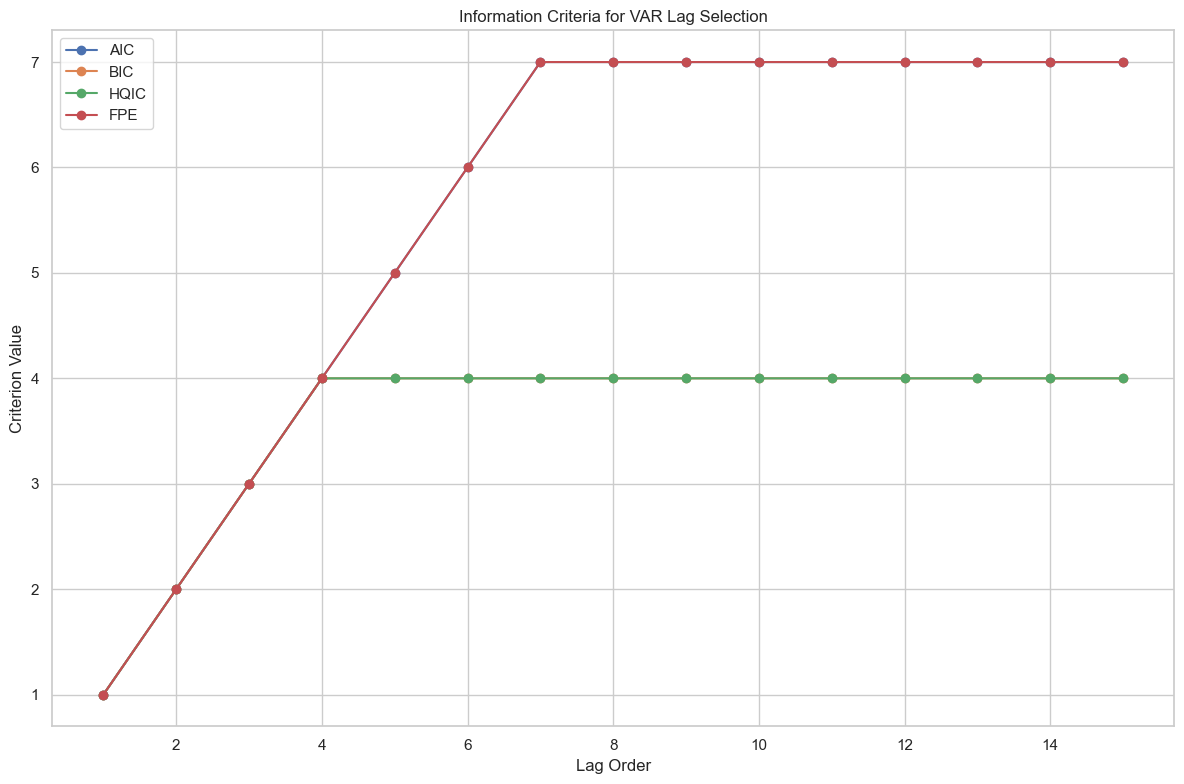

In [75]:
# Function to select optimal lag order
def select_var_order(data, max_lags=5):
    # Create a VAR model
    model = VAR(data)
    
    # Determine information criteria for different lag orders
    results = {}
    for i in range(1, max_lags + 1):
        results[i] = model.select_order(i)
    
    # Create a DataFrame to display the results
    criteria = ['aic', 'bic', 'hqic', 'fpe']
    order_df = pd.DataFrame(index=range(1, max_lags + 1), columns=criteria)
    
    for i in range(1, max_lags + 1):
        for criterion in criteria:
            order_df.loc[i, criterion] = getattr(results[i], criterion)
    
    return order_df

# Select optimal lag order
lag_order_results = select_var_order(train_df[["y2", "y10"]], max_lags=15)
print("Information criteria for different lag orders:")
print(lag_order_results)

# Plot the information criteria
plt.figure(figsize=(12, 8))
for column in lag_order_results.columns:
    plt.plot(lag_order_results.index, lag_order_results[column], marker='o', label=column.upper())
plt.xlabel('Lag Order')
plt.ylabel('Criterion Value')
plt.title('Information Criteria for VAR Lag Selection')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The information criteria suggest choosing either 4 or 7 lags. To keep the model simpler, we will start with 4 lags.

### 2.2. VECM with 4 lags

First, we will start by testing with 4 lags. If everything goes well, we will proceed to perform the forecast. 
However, if we find signs of model misspecification, we will repeat the same process using 7 lags instead.

#### 2.2.1. Johansen Test for cointegration

The Johansen test indicates the number of cointegrating vectors.  
For a system with two variables, the possible outcomes are:

- **0 cointegrating vectors (r = 0):** This suggests that there is no cointegration between the two variables.
- **1 cointegrating vector (r = 1):** This indicates that the two series are cointegrated.

In [76]:
# Perform Johansen test
# K=4 in levels VAR -> k_ar_diff = K-1 = 3 lags in VECM differences
# ecdet = "const" -> det_order = 0 (constant in CE)
data_for_test = train_df[['y2', 'y10']]
johansen_result = coint_johansen(data_for_test, det_order=0, k_ar_diff=3)

print("--- Interpretation (Trace Test) ---")
hypotheses_trace = ['r <= 0', 'r <= 1']
for i in range(len(hypotheses_trace)):
    print(f"H0: {hypotheses_trace[i]}")
    print(f"  Trace Statistic: {johansen_result.lr1[i]:.3f}")
    print(f"  Critical Value (95%): {johansen_result.cvt[i, 1]:.3f}")
    if johansen_result.lr1[i] > johansen_result.cvt[i, 1]:
        print("  Result: Reject H0 at 5% significance level.")
    else:
        print("  Result: Cannot reject H0 at 5% significance level.")

print("\n--- Interpretation (Max Eigenvalue Test) ---")
hypotheses_maxeig = ['r = 0', 'r = 1'] # H0: rank is r vs H1: rank is r+1
for i in range(len(hypotheses_maxeig)):
    print(f"H0: {hypotheses_maxeig[i]}")
    print(f"  Max Eigenvalue Statistic: {johansen_result.lr2[i]:.3f}")
    print(f"  Critical Value (95%): {johansen_result.cvt[i, 1]:.3f}")
    if johansen_result.lr2[i] > johansen_result.cvm[i, 1]:
        print("  Result: Reject H0 at 5% significance level.")
    else:
        print("  Result: Cannot reject H0 at 5% significance level.")

--- Interpretation (Trace Test) ---
H0: r <= 0
  Trace Statistic: 154.991
  Critical Value (95%): 15.494
  Result: Reject H0 at 5% significance level.
H0: r <= 1
  Trace Statistic: 5.737
  Critical Value (95%): 3.841
  Result: Reject H0 at 5% significance level.

--- Interpretation (Max Eigenvalue Test) ---
H0: r = 0
  Max Eigenvalue Statistic: 149.254
  Critical Value (95%): 15.494
  Result: Reject H0 at 5% significance level.
H0: r = 1
  Max Eigenvalue Statistic: 5.737
  Critical Value (95%): 3.841
  Result: Reject H0 at 5% significance level.


We reject the null hypothesis ($H₀$) for $r = 0$ (and $r ≤ 0$) and $r = 1$ (and $r ≤ 1$).  
This suggests that there are two cointegrating vectors (what doesn't make sense for two variabels). However, this would imply that both series move independently and, therefore, are not truly cointegrated.

Since the test statistics are very close to the critical values, we will repeat the test using a 99% confidence level.


In [77]:
# Perform Johansen test
# K=4 in levels VAR -> k_ar_diff = K-1 = 3 lags in VECM differences
# ecdet = "const" -> det_order = 0 (constant in CE)
data_for_test = train_df[['y2', 'y10']]
johansen_result = coint_johansen(data_for_test, det_order=0, k_ar_diff=3)

print("--- Interpretation (Trace Test) ---")
hypotheses_trace = ['r <= 0', 'r <= 1']
for i in range(len(hypotheses_trace)):
    print(f"H0: {hypotheses_trace[i]}")
    print(f"  Trace Statistic: {johansen_result.lr1[i]:.3f}")
    print(f"  Critical Value (99%): {johansen_result.cvt[i, 2]:.3f}")
    if johansen_result.lr1[i] > johansen_result.cvt[i, 2]:
        print("  Result: Reject H0 at 1% significance level.")
    else:
        print("  Result: Cannot reject H0 at 1% significance level.")

print("\n--- Interpretation (Max Eigenvalue Test) ---")
hypotheses_maxeig = ['r = 0', 'r = 1'] # H0: rank is r vs H1: rank is r+1
for i in range(len(hypotheses_maxeig)):
    print(f"H0: {hypotheses_maxeig[i]}")
    print(f"  Max Eigenvalue Statistic: {johansen_result.lr2[i]:.3f}")
    print(f"  Critical Value (99%): {johansen_result.cvt[i, 2]:.3f}")
    if johansen_result.lr2[i] > johansen_result.cvm[i, 2]:
        print("  Result: Reject H0 at 1% significance level.")
    else:
        print("  Result: Cannot reject H0 at 1% significance level.")


--- Interpretation (Trace Test) ---
H0: r <= 0
  Trace Statistic: 154.991
  Critical Value (99%): 19.935
  Result: Reject H0 at 1% significance level.
H0: r <= 1
  Trace Statistic: 5.737
  Critical Value (99%): 6.635
  Result: Cannot reject H0 at 1% significance level.

--- Interpretation (Max Eigenvalue Test) ---
H0: r = 0
  Max Eigenvalue Statistic: 149.254
  Critical Value (99%): 19.935
  Result: Reject H0 at 1% significance level.
H0: r = 1
  Max Eigenvalue Statistic: 5.737
  Critical Value (99%): 6.635
  Result: Cannot reject H0 at 1% significance level.


At a 99% confidence level, the results change as expected:  We **reject the null hypothesis (H₀) for r = 0**, but we **cannot reject it for r = 1**, which indicates that we have **one cointegrating vector** and therefore both series **are cointegrated**.

This conclusion is consistent with the Engle-Granger test we previously conducted, suggesting that a **99% confidence level is the appropriate choice**.




In [78]:
print("Eigenvectors (columns are potential cointegrating vectors, ordered by eigenvalue):")
print(johansen_result.evec)

print("\nCointegrating Vector (beta - first column of eigenvectors):")
coint_vector_raw = johansen_result.evec[:, 0]
print(coint_vector_raw)

# Normalize the first element to 1 for potentially easier interpretation
coint_vector_normalized = coint_vector_raw / coint_vector_raw[0]
print("\nCointegrating Vector (beta, normalized with ppi coefficient = 1):")
print(coint_vector_normalized)

Eigenvectors (columns are potential cointegrating vectors, ordered by eigenvalue):
[[ 41.36909547  -1.02493322]
 [-20.68642732   0.50058394]]

Cointegrating Vector (beta - first column of eigenvectors):
[ 41.36909547 -20.68642732]

Cointegrating Vector (beta, normalized with ppi coefficient = 1):
[ 1.         -0.50004543]


The cointegrating vector normalized with the coefficient of `y2` equal to 1 is `[1, -0.50]`, suggesting that in the long run, `y2` and `y10` move together with an approximately 2:1 relationship. This indicates a stable long-run equilibrium between both series.

#### 2.2.2. VECM model estimation

Let's build the VECM with the result that we got, 4 lags and 1 cointegration vector.

In [79]:
# Estimate VECM
vecm_model = VECM(data_for_test, k_ar_diff=3, coint_rank=1, deterministic='ci', freq= 'D')
vecm_results = vecm_model.fit()
print(vecm_results.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation y2
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.y2         -2.1442      1.567     -1.368      0.171      -5.216       0.928
L1.y10         1.6588      0.781      2.123      0.034       0.128       3.190
L2.y2         -1.0449      1.296     -0.806      0.420      -3.585       1.495
L2.y10         0.2576      0.647      0.398      0.691      -1.011       1.526
L3.y2         -0.3412      0.908     -0.376      0.707      -2.121       1.439
L3.y10         0.2758      0.456      0.605      0.545      -0.617       1.169
Det. terms outside the coint. relation & lagged endog. parameters for equation y10
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.y2         -4.4428      3.146     -1.412  

In [80]:
print("\nCointegrating Vector (beta) from VECM results:")
# Note: statsmodels VECM beta might be scaled differently than R's urca.
# The interpretation depends on the normalization.
print(vecm_results.beta)

# Let's normalize the first element to 1 for comparison with previous result
beta_normalized_vecm = vecm_results.beta[:, 0] / vecm_results.beta[0, 0]
print("\nCointegrating Vector (beta, normalized with y2 = 1):")
print(beta_normalized_vecm)

print("\nAdjustment Coefficients (alpha) from VECM results:")
print(vecm_results.alpha)


Cointegrating Vector (beta) from VECM results:
[[ 1.        ]
 [-0.50004544]]

Cointegrating Vector (beta, normalized with y2 = 1):
[ 1.         -0.50004544]

Adjustment Coefficients (alpha) from VECM results:
[[ 4.85612712]
 [11.86626888]]


Let's estimate a VAR model with the same number of lags to estimate the Impulse Response Function and the Forecast Error Variance Decomposition.

In [81]:
# Estimate VAR
var_model = VAR(data_for_test)
var_results = var_model.fit(4)

#### 2.2.3. Impulse Response Function (IRF)

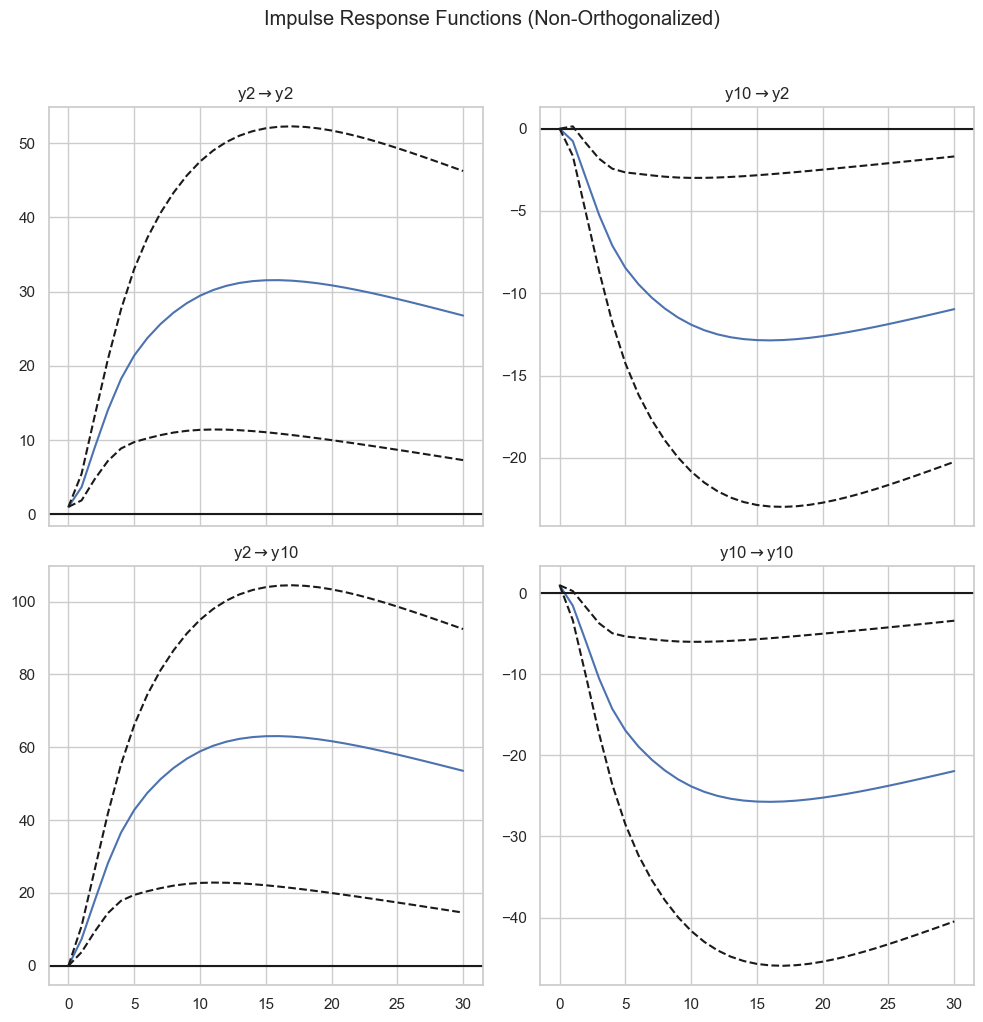

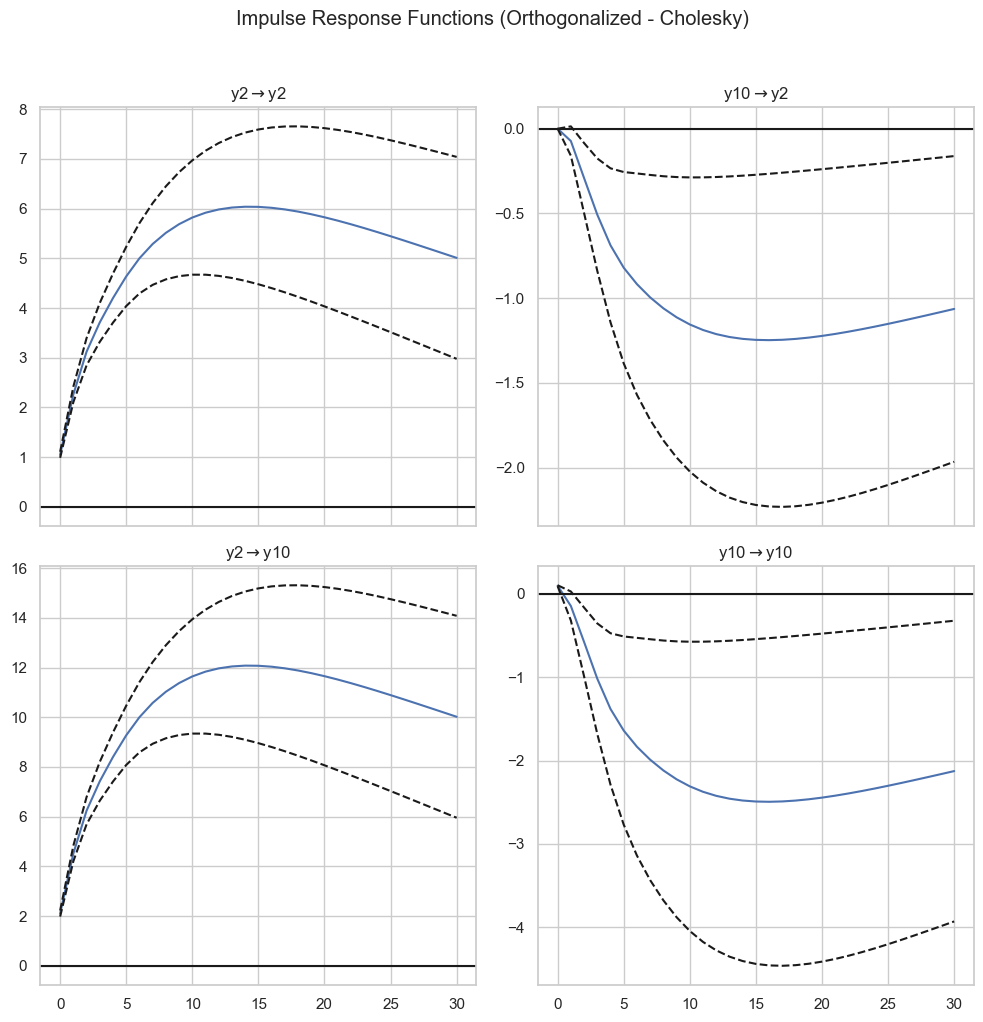

In [82]:
# Calculate and plot IRFs
irf = var_results.irf(periods=30)

# Non-orthogonalized IRFs
irf.plot(orth=False)
plt.suptitle('Impulse Response Functions (Non-Orthogonalized)', y=1.02)
plt.tight_layout()
plt.show()

# Orthogonalized IRFs (using Cholesky decomposition by default)
irf.plot(orth=True)
plt.suptitle('Impulse Response Functions (Orthogonalized - Cholesky)', y=1.02)
plt.tight_layout()
plt.show()


The IRF display the dynamic interactions between `y2` and `y10` over a 30-period horizon. Shocks to either variable produce statistically significant and persistent responses in both series, confirming the existence of long-run interdependence.

Notably, `y2` shocks tend to generate positive effects, while `y10` shocks induce negative responses. These patterns are consistent with the previously identified cointegrating relationship and provide further support for the use of a VECM framework in forecasting and structural analysis.


#### 2.2.4. Forecast Error Variance Decomposition

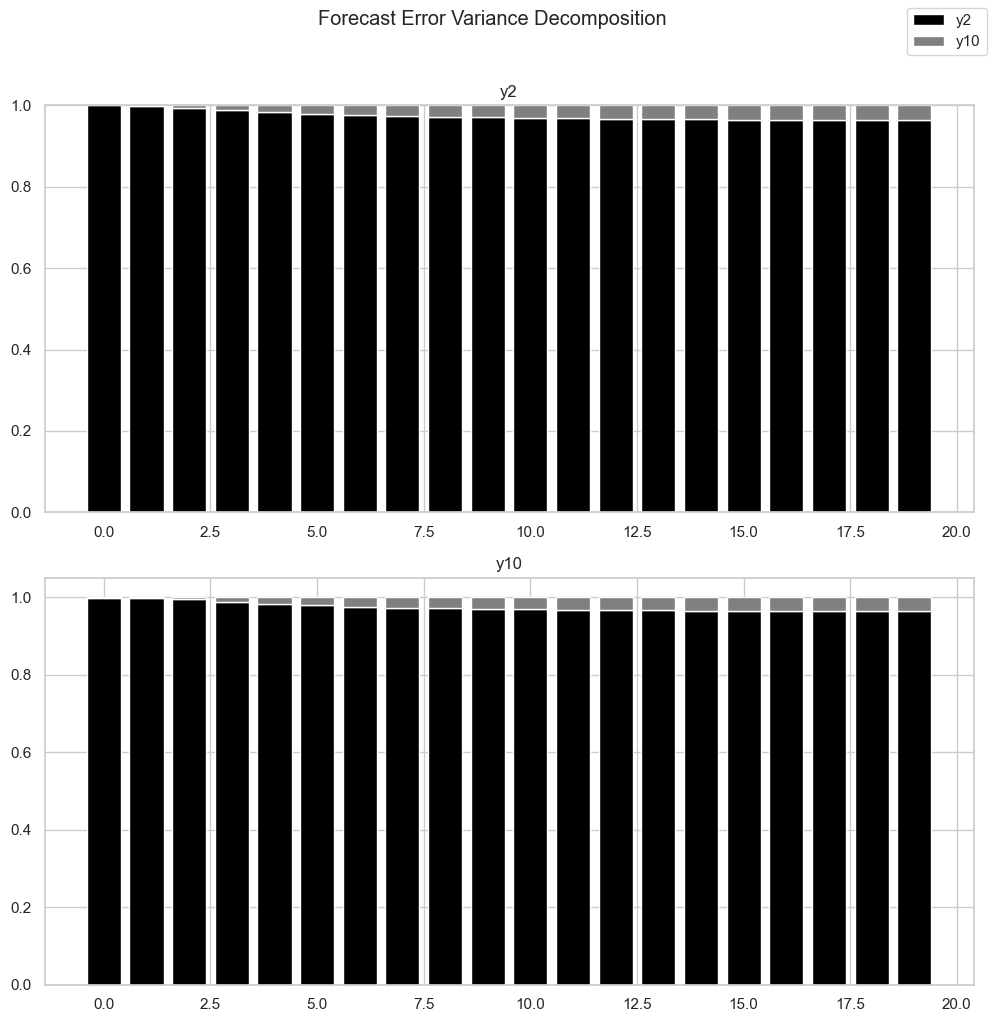


FEVD Summary (Period 20):
FEVD for y2
            y2       y10
0     1.000000  0.000000
1     0.999150  0.000850
2     0.994394  0.005606
3     0.988457  0.011543
4     0.982980  0.017020
5     0.978784  0.021216
6     0.975745  0.024255
7     0.973446  0.026554
8     0.971622  0.028378
9     0.970126  0.029874
10    0.968877  0.031123
11    0.967822  0.032178
12    0.966923  0.033077
13    0.966149  0.033851
14    0.965480  0.034520
15    0.964897  0.035103
16    0.964385  0.035615
17    0.963934  0.036066
18    0.963535  0.036465
19    0.963179  0.036821

FEVD for y10
            y2       y10
0     0.997875  0.002125
1     0.998766  0.001234
2     0.994320  0.005680
3     0.988349  0.011651
4     0.982834  0.017166
5     0.978680  0.021320
6     0.975666  0.024334
7     0.973388  0.026612
8     0.971578  0.028422
9     0.970090  0.029910
10    0.968847  0.031153
11    0.967796  0.032204
12    0.966900  0.033100
13    0.966129  0.033871
14    0.965462  0.034538
15    0.964880  0.0351

In [83]:
# Calculate and plot FEVD
fevd = var_results.fevd(periods=20)
fevd.plot()
plt.suptitle('Forecast Error Variance Decomposition', y=1.02)
plt.tight_layout()
plt.show()

# Print FEVD summary for the last period
print("\nFEVD Summary (Period 20):")
print(fevd.summary())

The FEVD results reveal that most of the forecast error variance of `y10` is explained by shocks to `y2`, indicating that `y2` has a dominant influence in the system. In contrast, `y2`'s forecast variance is almost entirely driven by its own shocks, showing it behaves as the leading variable.

#### 2.2.5. Test for Autocorrelation and Normality of residuals

In [84]:
residuals = vecm_results.resid
# to DataFrame
residuals = pd.DataFrame(residuals, columns=['y2', 'y10'], index=train_df.index[4:])
print("Residuals (first 5 rows):")
print(residuals.head())

# Test for serial correlation (Ljung-Box test on residuals)
# Apply to each residual series separately
print("\nLjung-Box Test for Serial Correlation in Residuals (lag=10):")
ljung_box_y2 = acorr_ljungbox(residuals['y2'], lags=[10], return_df=True)
ljung_box_y10 = acorr_ljungbox(residuals['y10'], lags=[10], return_df=True)
print("y2 Residuals:\n", ljung_box_y2)
print("\ny10 Residuals:\n", ljung_box_y10)

# Check p-values
alpha_serial = 0.05
print(f"\nConclusion at alpha={alpha_serial}:")
if ljung_box_y2['lb_pvalue'].iloc[0] < alpha_serial:
    print(" - Reject H0 (no serial correlation) for y2 residuals.")
else:
    print(" - Cannot reject H0 (no serial correlation) for y2 residuals.")
if ljung_box_y10['lb_pvalue'].iloc[0] < alpha_serial:
    print(" - Reject H0 (no serial correlation) for y10 residuals.")
else:
    print(" - Cannot reject H0 (no serial correlation) for y10 residuals.")

Residuals (first 5 rows):
                      y2           y10
date                                  
2023-09-13 -0.2641554608 -0.7276907692
2023-09-14  1.8360275076  3.6748903305
2023-09-15 -0.0371904953 -0.1885496815
2023-09-16  0.5265269436  1.1670930182
2023-09-17  1.5276951025  2.9686913144

Ljung-Box Test for Serial Correlation in Residuals (lag=10):
y2 Residuals:
          lb_stat    lb_pvalue
10 29.1342382777 0.0011851865

y10 Residuals:
          lb_stat    lb_pvalue
10 28.6637118467 0.0014121334

Conclusion at alpha=0.05:
 - Reject H0 (no serial correlation) for y2 residuals.
 - Reject H0 (no serial correlation) for y10 residuals.


The null hypothesis of no serial correlation is rejected for both residual series, indicating potential model misspecification (e.g., incorrect lag order or omitted variables).

We may consider using a VECM with 7 lags, as previous evidence supports this approach.

Before changing the number of residuals lets analyze ACF and PACF 

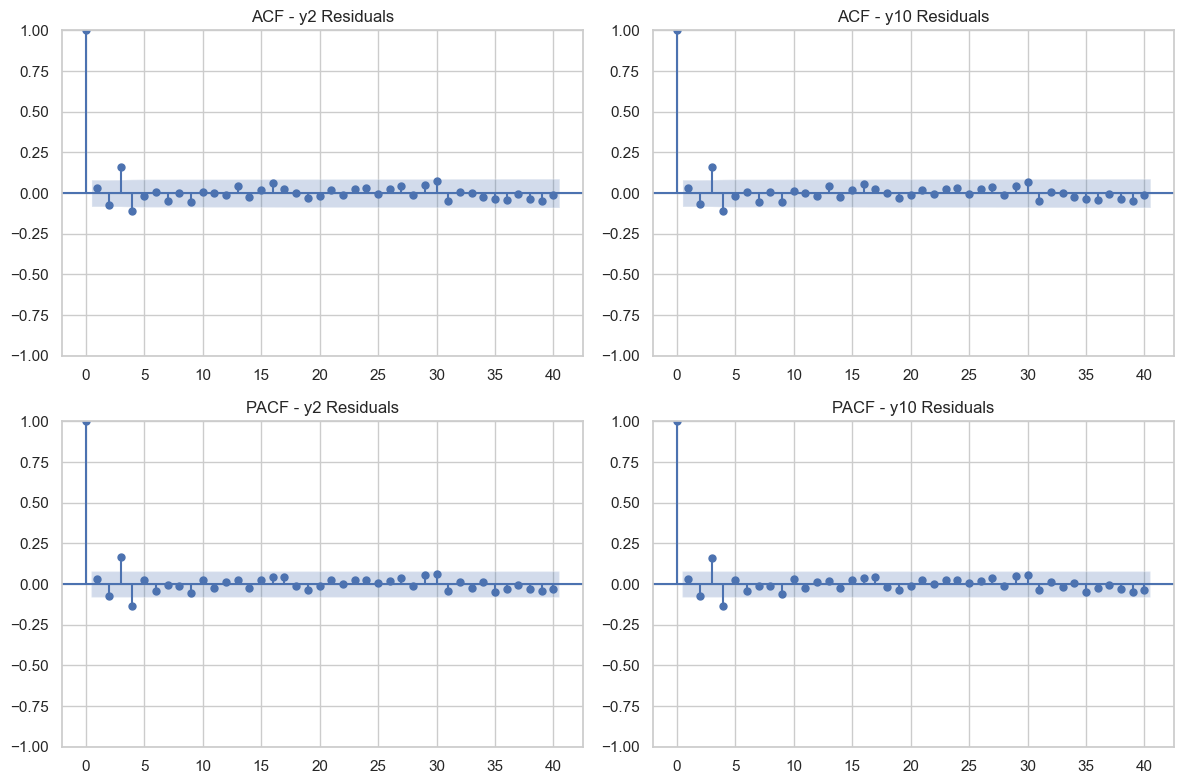

In [85]:
# Plot ACF and PACF of residuals
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_acf(residuals['y2'], ax=axes[0, 0], title='ACF - y2 Residuals', lags=40)
plot_pacf(residuals['y2'], ax=axes[1, 0], title='PACF - y2 Residuals', lags=40, method='ywm') # 'ols' method might fail if near non-stationarity
plot_acf(residuals['y10'], ax=axes[0, 1], title='ACF - y10 Residuals', lags=40)
plot_pacf(residuals['y10'], ax=axes[1, 1], title='PACF - y10 Residuals', lags=40, method='ywm')
plt.tight_layout()
plt.show()

Significant third and fourth lags were found in the ACF and PACF analyses, which may once again indicate an inappropriate number of lags. Let's try with 7 lags.

### 2.3. VECM with 7 lags

We will repeat the same process we previously performed using 4 lags, but now **using 7 lags**. If the number of lags is sufficient this time, we will proceed with the forecast.

Since we have already conducted most of the tests for the 4-lag model, I will skip commenting on those that show very similar results to the ones already discussed for 4 lags.

#### 2.3.1. Johansen Test for cointegration

In [86]:
# Perform Johansen test
# K=4 in levels VAR -> k_ar_diff = K-1 = 3 lags in VECM differences
# ecdet = "const" -> det_order = 0 (constant in CE)
data_for_test = train_df[['y2', 'y10']]
johansen_result = coint_johansen(data_for_test, det_order=0, k_ar_diff=6)

print("--- Interpretation (Trace Test) ---")
hypotheses_trace = ['r <= 0', 'r <= 1']
for i in range(len(hypotheses_trace)):
    print(f"H0: {hypotheses_trace[i]}")
    print(f"  Trace Statistic: {johansen_result.lr1[i]:.3f}")
    print(f"  Critical Value (99%): {johansen_result.cvt[i, 2]:.3f}")
    if johansen_result.lr1[i] > johansen_result.cvt[i, 2]:
        print("  Result: Reject H0 at 1% significance level.")
    else:
        print("  Result: Cannot reject H0 at 1% significance level.")

print("\n--- Interpretation (Max Eigenvalue Test) ---")
hypotheses_maxeig = ['r = 0', 'r = 1'] # H0: rank is r vs H1: rank is r+1
for i in range(len(hypotheses_maxeig)):
    print(f"H0: {hypotheses_maxeig[i]}")
    print(f"  Max Eigenvalue Statistic: {johansen_result.lr2[i]:.3f}")
    print(f"  Critical Value (99%): {johansen_result.cvt[i, 2]:.3f}")
    if johansen_result.lr2[i] > johansen_result.cvm[i, 2]:
        print("  Result: Reject H0 at 1% significance level.")
    else:
        print("  Result: Cannot reject H0 at 1% significance level.")


--- Interpretation (Trace Test) ---
H0: r <= 0
  Trace Statistic: 86.976
  Critical Value (99%): 19.935
  Result: Reject H0 at 1% significance level.
H0: r <= 1
  Trace Statistic: 4.181
  Critical Value (99%): 6.635
  Result: Cannot reject H0 at 1% significance level.

--- Interpretation (Max Eigenvalue Test) ---
H0: r = 0
  Max Eigenvalue Statistic: 82.796
  Critical Value (99%): 19.935
  Result: Reject H0 at 1% significance level.
H0: r = 1
  Max Eigenvalue Statistic: 4.181
  Critical Value (99%): 6.635
  Result: Cannot reject H0 at 1% significance level.


In [87]:
print("Eigenvectors (columns are potential cointegrating vectors, ordered by eigenvalue):")
print(johansen_result.evec)

print("\nCointegrating Vector (beta - first column of eigenvectors):")
coint_vector_raw = johansen_result.evec[:, 0]
print(coint_vector_raw)

# Normalize the first element to 1 for potentially easier interpretation
coint_vector_normalized = coint_vector_raw / coint_vector_raw[0]
print("\nCointegrating Vector (beta, normalized with ppi coefficient = 1):")
print(coint_vector_normalized)

Eigenvectors (columns are potential cointegrating vectors, ordered by eigenvalue):
[[ 56.60970772  -3.41587246]
 [-28.30802006   1.69602695]]

Cointegrating Vector (beta - first column of eigenvectors):
[ 56.60970772 -28.30802006]

Cointegrating Vector (beta, normalized with ppi coefficient = 1):
[ 1.         -0.50005593]


The results of the Johansen test indicate that we have one cointegration vector. These results are very similar to those obtained with 4 lags.

#### 2.3.2. VECM estimation

In [88]:
# Estimate VECM
vecm_model = VECM(data_for_test, k_ar_diff=6, coint_rank=1, deterministic='ci', freq= 'D')
vecm_results = vecm_model.fit()
print(vecm_results.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation y2
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.y2         -3.1960      2.228     -1.434      0.151      -7.563       1.171
L1.y10         2.2184      1.112      1.995      0.046       0.039       4.398
L2.y2         -2.7911      2.019     -1.383      0.167      -6.747       1.165
L2.y10         1.0461      1.009      1.037      0.300      -0.931       3.023
L3.y2         -1.1244      1.781     -0.631      0.528      -4.616       2.367
L3.y10         0.8246      0.889      0.928      0.354      -0.918       2.567
L4.y2         -1.6100      1.532     -1.051      0.293      -4.613       1.393
L4.y10         0.6085      0.765      0.795      0.427      -0.891       2.108
L5.y2         -1.6404      1.268     -1.294      0.196      -4.125       0.844
L5.y10         0.9535      0.633      1.506      

In [89]:
print("\nCointegrating Vector (beta) from VECM results:")
# Note: statsmodels VECM beta might be scaled differently than R's urca.
# The interpretation depends on the normalization.
print(vecm_results.beta)

# Let's normalize the first element to 1 for comparison with previous result
beta_normalized_vecm = vecm_results.beta[:, 0] / vecm_results.beta[0, 0]
print("\nCointegrating Vector (beta, normalized with ppi=1):")
print(beta_normalized_vecm)

print("\nAdjustment Coefficients (alpha) from VECM results:")
print(vecm_results.alpha)


Cointegrating Vector (beta) from VECM results:
[[ 1.        ]
 [-0.50005594]]

Cointegrating Vector (beta, normalized with ppi=1):
[ 1.         -0.50005594]

Adjustment Coefficients (alpha) from VECM results:
[[ 6.02700523]
 [14.16027819]]


In [90]:
# Estimate VAR
var7_model = VAR(data_for_test)
var7_results = var_model.fit(7)

#### 2.3.3. Impulse Response Function (IRF)

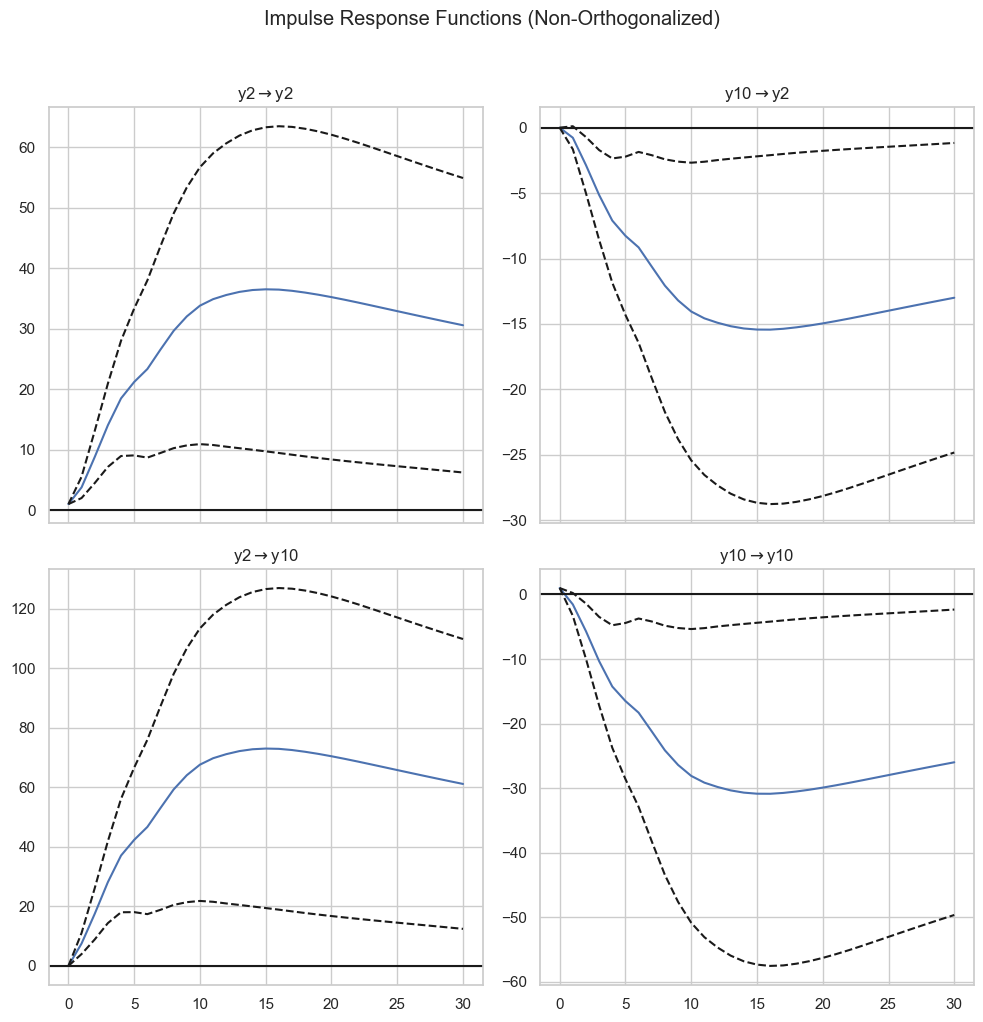

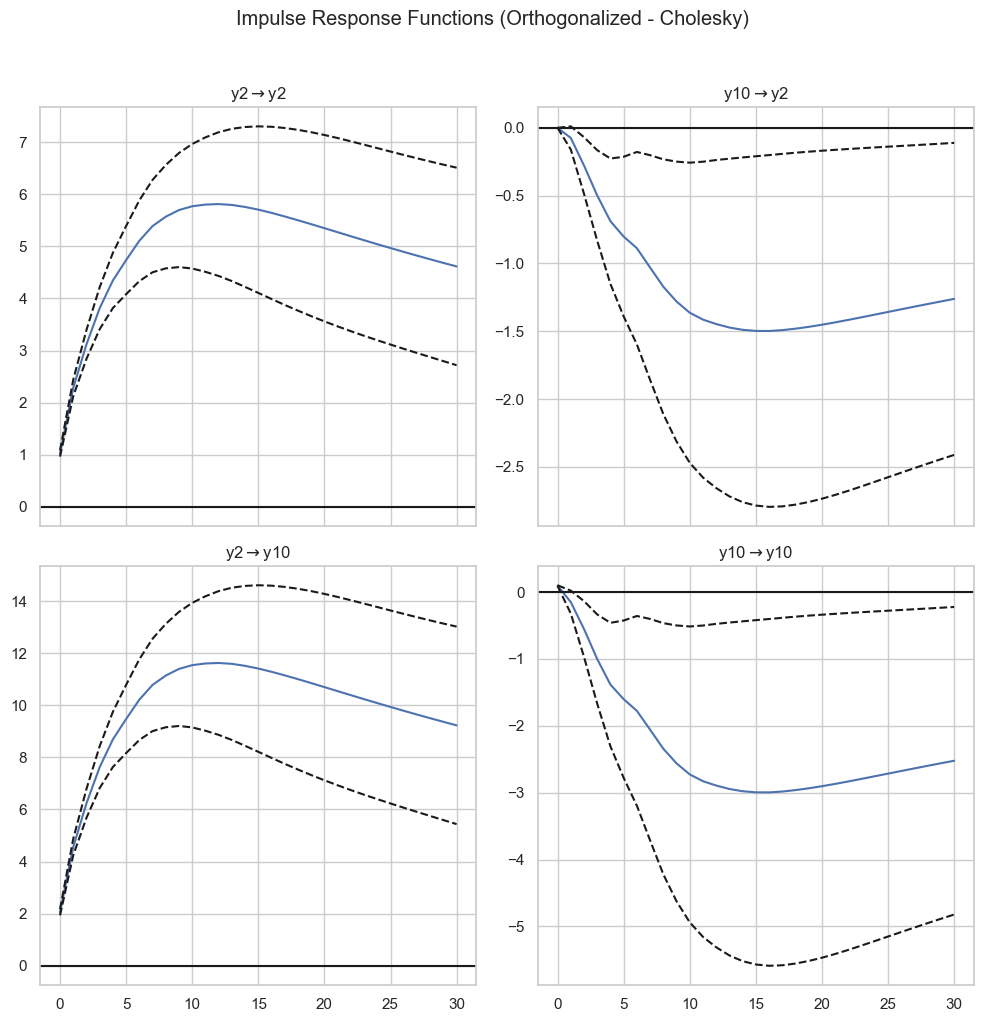

In [91]:
# Calculate and plot IRFs
irf = var7_results.irf(periods=30)

# Non-orthogonalized IRFs
irf.plot(orth=False)
plt.suptitle('Impulse Response Functions (Non-Orthogonalized)', y=1.02)
plt.tight_layout()
plt.show()

# Orthogonalized IRFs (using Cholesky decomposition by default)
irf.plot(orth=True)
plt.suptitle('Impulse Response Functions (Orthogonalized - Cholesky)', y=1.02)
plt.tight_layout()
plt.show()

Results very similar to the IRF with 4 lags; therefore, the same conclusion applies.

#### 2.2.4. Forecast Error Variance Decomposition

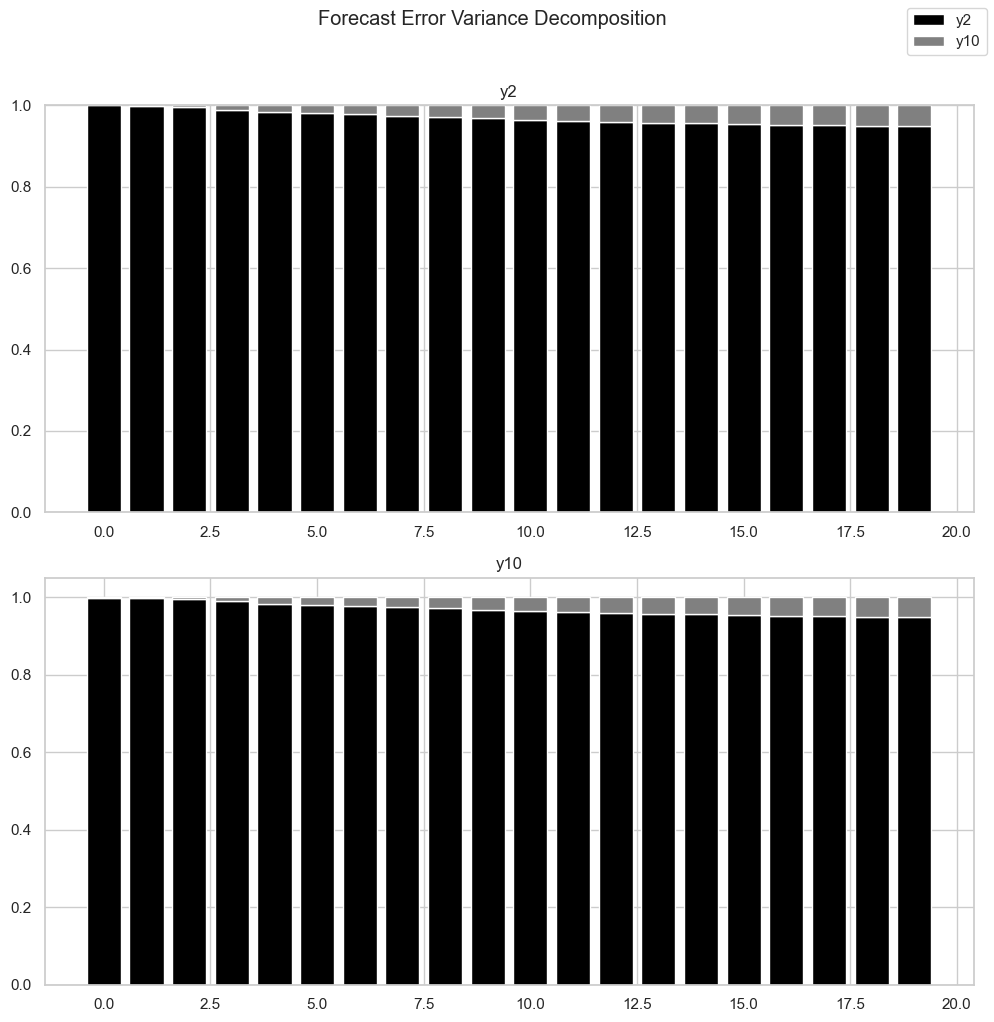


FEVD Summary (Period 20):
FEVD for y2
            y2       y10
0     1.000000  0.000000
1     0.999113  0.000887
2     0.994840  0.005160
3     0.989238  0.010762
4     0.983933  0.016067
5     0.980216  0.019784
6     0.977657  0.022343
7     0.974669  0.025331
8     0.971274  0.028726
9     0.967912  0.032088
10    0.964758  0.035242
11    0.961981  0.038019
12    0.959576  0.040424
13    0.957444  0.042556
14    0.955538  0.044462
15    0.953839  0.046161
16    0.952327  0.047673
17    0.950989  0.049011
18    0.949806  0.050194
19    0.948757  0.051243

FEVD for y10
            y2       y10
0     0.997776  0.002224
1     0.998734  0.001266
2     0.994748  0.005252
3     0.989120  0.010880
4     0.983778  0.016222
5     0.980130  0.019870
6     0.977586  0.022414
7     0.974639  0.025361
8     0.971253  0.028747
9     0.967895  0.032105
10    0.964743  0.035257
11    0.961966  0.038034
12    0.959563  0.040437
13    0.957431  0.042569
14    0.955527  0.044473
15    0.953828  0.0461

In [92]:

# Calculate and plot FEVD
fevd = var7_results.fevd(periods=20)
fevd.plot()
plt.suptitle('Forecast Error Variance Decomposition', y=1.02)
plt.tight_layout()
plt.show()

# Print FEVD summary for the last period
print("\nFEVD Summary (Period 20):")
print(fevd.summary())

As in the previous step, the FEVD provides results very similar to those with 4 lags.

#### 2.3.5. Test for Autocorrelation and Normality of residuals

In [93]:
residuals = vecm_results.resid
# to DataFrame
residuals = pd.DataFrame(residuals, columns=['y2', 'y10'], index=train_df.index[7:])
print("Residuals (first 5 rows):")
print(residuals.head())

# Test for serial correlation (Ljung-Box test on residuals)
# Apply to each residual series separately
print("\nLjung-Box Test for Serial Correlation in Residuals (lag=10):")
ljung_box_y2 = acorr_ljungbox(residuals['y2'], lags=[10], return_df=True)
ljung_box_y10 = acorr_ljungbox(residuals['y10'], lags=[10], return_df=True)
print("y2 Residuals:\n", ljung_box_y2)
print("\ny10 Residuals:\n", ljung_box_y10)

# Check p-values
alpha_serial = 0.05
print(f"\nConclusion at alpha={alpha_serial}:")
if ljung_box_y2['lb_pvalue'].iloc[0] < alpha_serial:
    print(" - Reject H0 (no serial correlation) for y2 residuals.")
else:
    print(" - Cannot reject H0 (no serial correlation) for y2 residuals.")
if ljung_box_y10['lb_pvalue'].iloc[0] < alpha_serial:
    print(" - Reject H0 (no serial correlation) for y10 residuals.")
else:
    print(" - Cannot reject H0 (no serial correlation) for y10 residuals.")

Residuals (first 5 rows):
                      y2           y10
date                                  
2023-09-16  0.6791049685  1.4700285422
2023-09-17  1.1040611660  2.1212151621
2023-09-18  0.7081078658  1.4673685458
2023-09-19 -0.9392497076 -1.7304628735
2023-09-20  1.0840490313  2.3238928920

Ljung-Box Test for Serial Correlation in Residuals (lag=10):
y2 Residuals:
         lb_stat    lb_pvalue
10 3.8425034175 0.9541723253

y10 Residuals:
         lb_stat    lb_pvalue
10 4.1870385988 0.9385150857

Conclusion at alpha=0.05:
 - Cannot reject H0 (no serial correlation) for y2 residuals.
 - Cannot reject H0 (no serial correlation) for y10 residuals.


We can now reject the presence of serial correlation for both residual series, suggesting that a model with 7 lags provides a better fit.

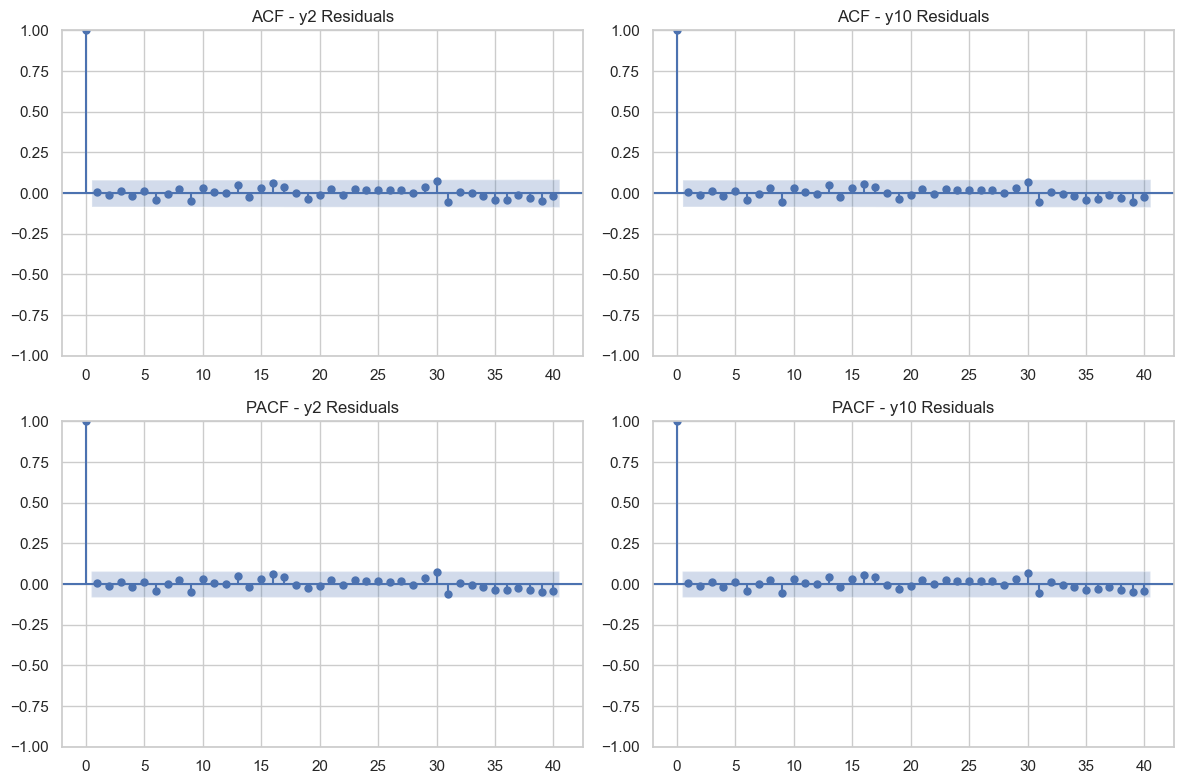

In [94]:
# Plot ACF and PACF of residuals
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_acf(residuals['y2'], ax=axes[0, 0], title='ACF - y2 Residuals', lags=40)
plot_pacf(residuals['y2'], ax=axes[1, 0], title='PACF - y2 Residuals', lags=40, method='ywm') # 'ols' method might fail if near non-stationarity
plot_acf(residuals['y10'], ax=axes[0, 1], title='ACF - y10 Residuals', lags=40)
plot_pacf(residuals['y10'], ax=axes[1, 1], title='PACF - y10 Residuals', lags=40, method='ywm')
plt.tight_layout()
plt.show()

We have eliminated all significant residuals, once again, it appears that our model performs better with 7 lags.

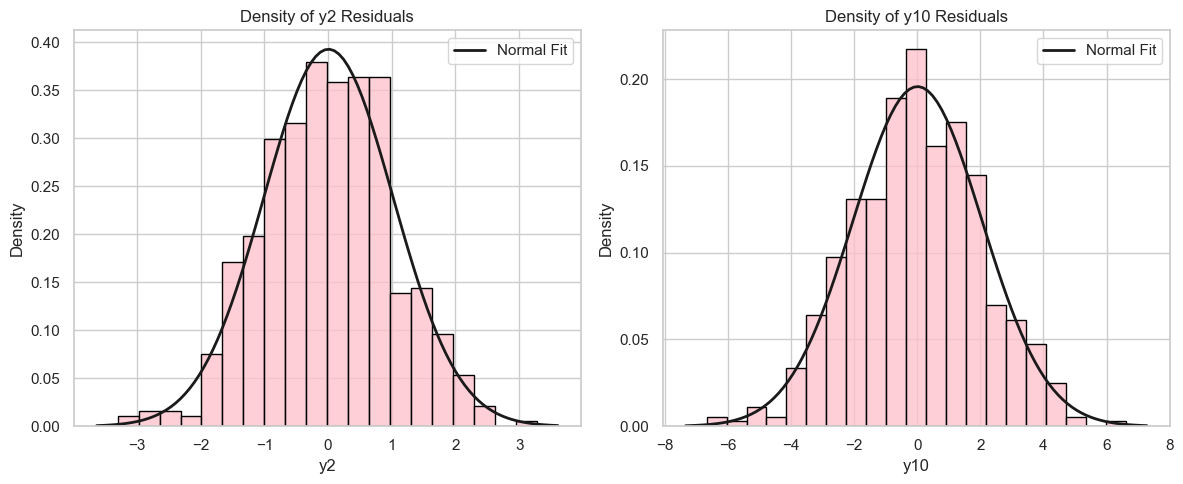

In [95]:
# Plot histograms of residuals with normal density overlay
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(residuals['y2'], kde=False, stat='density', ax=axes[0], color='pink', edgecolor='black')
axes[0].set_title('Density of y2 Residuals')
# Overlay normal distribution
mu_y2, std_y2 = residuals['y2'].mean(), residuals['y2'].std()
xmin_y2, xmax_y2 = axes[0].get_xlim()
x_y2 = np.linspace(xmin_y2, xmax_y2, 100)
p_y2 = norm.pdf(x_y2, mu_y2, std_y2)
axes[0].plot(x_y2, p_y2, 'k', linewidth=2, label='Normal Fit')
axes[0].legend()

sns.histplot(residuals['y10'], kde=False, stat='density', ax=axes[1], color='pink', edgecolor='black')
axes[1].set_title('Density of y10 Residuals')
# Overlay normal distribution
mu_y10, std_y10 = residuals['y10'].mean(), residuals['y10'].std()
xmin_y10, xmax_y10 = axes[1].get_xlim()
x_y10 = np.linspace(xmin_y10, xmax_y10, 100)
p_y10 = norm.pdf(x_y10, mu_y10, std_y10)
axes[1].plot(x_y10, p_y10, 'k', linewidth=2, label='Normal Fit')
axes[1].legend()

plt.tight_layout()
plt.show()

The residuals appear to be normally distributed. To check assess this, we will conduct the Jarque-Bera test.

In [96]:
# Test for normality (Jarque-Bera test)
jb_y2_stat, jb_y2_pval, _, _ = jarque_bera(residuals['y2'])
jb_y10_stat, jb_y10_pval, _, _ = jarque_bera(residuals['y10'])

print("\nJarque-Bera Normality Test for Residuals:")
print(f"y2 Residuals: Statistic={jb_y2_stat:.3f}, p-value={jb_y2_pval:.3f}")
print(f"y10 Residuals: Statistic={jb_y10_stat:.3f}, p-value={jb_y10_pval:.3f}")

alpha_norm = 0.05
print(f"\nConclusion at alpha={alpha_norm}:")
if jb_y2_pval < alpha_norm:
    print(" - Reject normality for y2 residuals.")
else:
    print(" - Cannot reject normality for y2 residuals.")
if jb_y10_pval < alpha_norm:
    print(" - Reject normality for y10 residuals.")
else:
    print(" - Cannot reject normality for y10 residuals.")

# Multivariate Normality Test (using VECMResults method)
try:
    normality_test_results = vecm_results.test_normality()
    print("\nMultivariate Normality Test Results (using VECMResults method):")
    print(normality_test_results)
except Exception as e:
    print(f"\nCould not run multivariate normality test directly: {e}")


Jarque-Bera Normality Test for Residuals:
y2 Residuals: Statistic=0.192, p-value=0.909
y10 Residuals: Statistic=0.200, p-value=0.905

Conclusion at alpha=0.05:
 - Cannot reject normality for y2 residuals.
 - Cannot reject normality for y10 residuals.

Multivariate Normality Test Results (using VECMResults method):
<statsmodels.tsa.vector_ar.hypothesis_test_results.NormalityTestResults object. H_0: data generated by normally-distributed process: fail to reject at 5% significance level. Test statistic: 2.493, critical value: 9.488>, p-value: 0.646>


Consistent with the plot, we do not have enough evidence to reject the null hypothesis that the residuals are normally distributed.

#### 2.3.6. Forecasting with VECM

Now, we will build the model with `7 lags` and `cointegration rank 1` using the training dataset and compare the fitted values with the actual values from the test dataset.

In [97]:
# Re-estimate VECM on shorter sample
vecm_model_short = VECM(train_df[["y2", "y10"]], k_ar_diff=6, coint_rank=1, deterministic='ci', freq="D")
vecm_results_short = vecm_model_short.fit()

# Generate forecasts
forecast_values = vecm_results_short.predict(steps=25)
forecast_intervals = vecm_results_short.predict(steps=25, alpha=0.05) # alpha=0.05 for 95% CI

# Create forecast DataFrame
forecast_index = test_df.index
forecast_df = pd.DataFrame(forecast_values, index=forecast_index, columns=['y2_fore', 'y10_fore'])

print(forecast_df)

                  y2_fore       y10_fore
date                                    
2025-04-06 160.0221125851 220.6600084084
2025-04-07 158.6865687979 217.9766972936
2025-04-08 157.5229198493 215.6407805713
2025-04-09 156.4902006348 213.5745425051
2025-04-10 155.8644500298 212.3278518085
2025-04-11 155.2944148185 211.1871346524
2025-04-12 154.7349890363 210.0700478793
2025-04-13 154.3348535721 209.2688726059
2025-04-14 154.0200900727 208.6392673189
2025-04-15 153.7873511442 208.1739872323
2025-04-16 153.6488008190 207.8973304384
2025-04-17 153.5467246747 207.6936316138
2025-04-18 153.4736426396 207.5475297463
2025-04-19 153.4334835212 207.4675036350
2025-04-20 153.4095110968 207.4197418881
2025-04-21 153.3999190919 207.4007429936
2025-04-22 153.4024633434 207.4060259424
2025-04-23 153.4087545012 207.4187098298
2025-04-24 153.4176636279 207.4366094367
2025-04-25 153.4285861493 207.4585146221
2025-04-26 153.4391867266 207.4797602969
2025-04-27 153.4494121203 207.5002480780
2025-04-28 153.4

These are the forecasted values for each variable.

In [98]:
# Create forecast interval DataFrames
forecast_lower = pd.DataFrame(forecast_intervals[1], index=forecast_index, columns=['y2_lower', 'y10_lower'])
forecast_upper = pd.DataFrame(forecast_intervals[2], index=forecast_index, columns=['y2_upper', 'y10_upper'])

# Combine forecasts and intervals
forecast_combined = pd.concat([forecast_df, forecast_lower, forecast_upper], axis=1)
print("\nForecasts and Confidence Intervals:")
print(forecast_combined)


Forecasts and Confidence Intervals:
                  y2_fore       y10_fore       y2_lower      y10_lower  \
date                                                                     
2025-04-06 160.0221125851 220.6600084084 158.0337510922 216.6672783345   
2025-04-07 158.6865687979 217.9766972936 153.8149703243 208.2423874606   
2025-04-08 157.5229198493 215.6407805713 149.6967021003 199.9984656970   
2025-04-09 156.4902006348 213.5745425051 145.6060184102 191.8169849275   
2025-04-10 155.8644500298 212.3278518085 141.9293356851 184.4678169483   
2025-04-11 155.2944148185 211.1871346524 138.3973065623 177.4026200775   
2025-04-12 154.7349890363 210.0700478793 134.9093193076 170.4265152184   
2025-04-13 154.3348535721 209.2688726059 131.6452923057 163.8956737145   
2025-04-14 154.0200900727 208.6392673189 128.5773687005 157.7586653820   
2025-04-15 153.7873511442 208.1739872323 125.7057228540 152.0149623605   
2025-04-16 153.6488008190 207.8973304384 123.0511933910 146.7061914715   
2

We calculate the confidence interval using the upper and lower values for each variable, applying a 95% confidence level.

Let's plot the results to visualize how our prediction compares to the actual data.

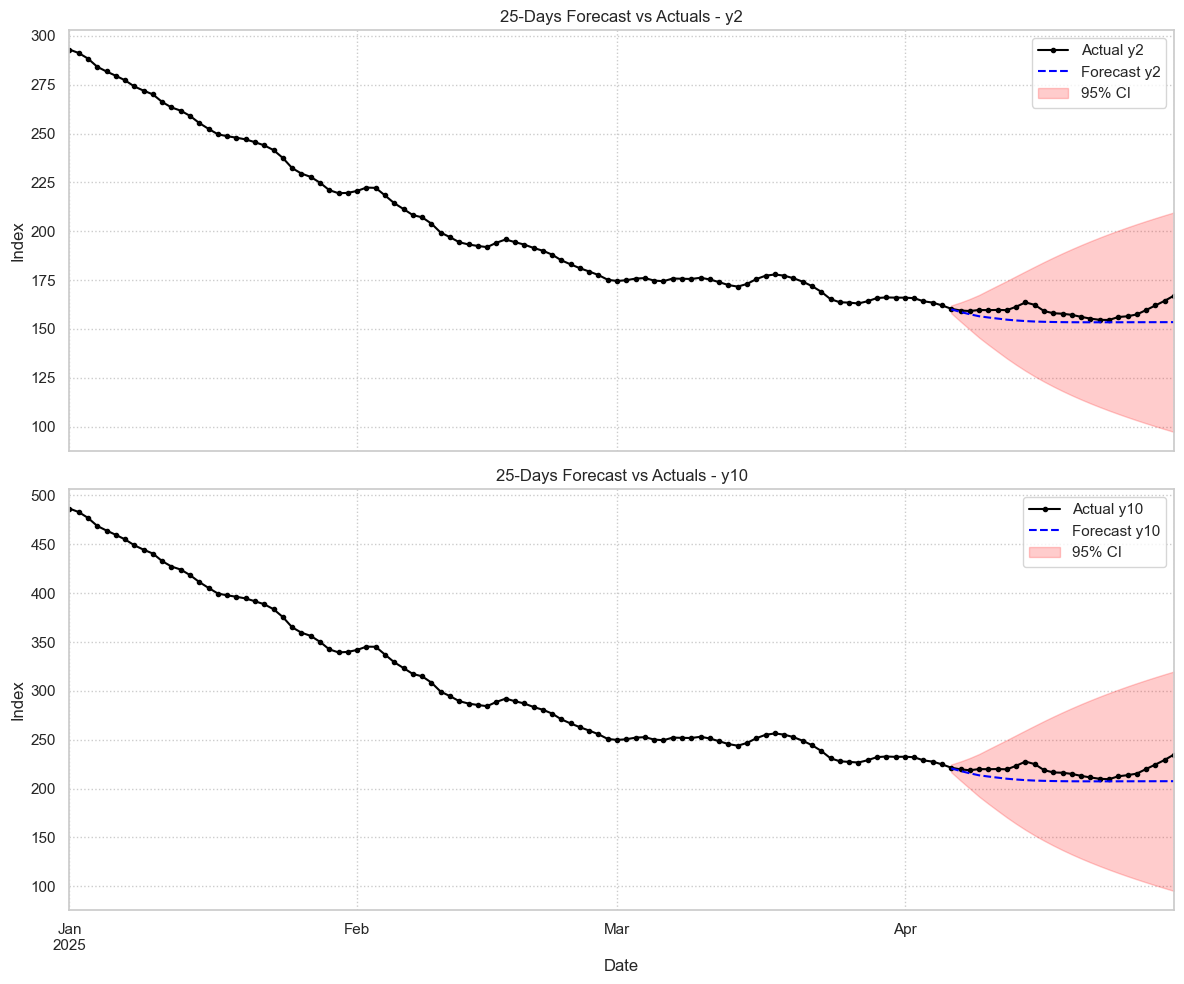

In [99]:
# Merge forecasts with the original data for plotting
df_merged = df.merge(forecast_combined, left_index=True, right_index=True, how='left')

# Plot forecasts vs actuals
plot_start_date = '2025-01-01' # Start date for the plot window

fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# y2 Plot
df_merged.loc[plot_start_date:, 'y2'].plot(ax=axes[0], label='Actual y2', color='black', marker='.')
df_merged.loc[plot_start_date:, 'y2_fore'].plot(ax=axes[0], label='Forecast y2', color='blue', linestyle='--')
axes[0].fill_between(df_merged.loc[plot_start_date:].index, # Ensure index alignment
                     df_merged.loc[plot_start_date:, 'y2_lower'],
                     df_merged.loc[plot_start_date:, 'y2_upper'], color='red', alpha=0.2, label='95% CI')
axes[0].set_title('25-Days Forecast vs Actuals - y2')
axes[0].set_ylabel('Index')
axes[0].legend()
axes[0].grid(True, linestyle=':')

# y10 Plot
df_merged.loc[plot_start_date:, 'y10'].plot(ax=axes[1], label='Actual y10', color='black', marker='.')
df_merged.loc[plot_start_date:, 'y10_fore'].plot(ax=axes[1], label='Forecast y10', color='blue', linestyle='--')
axes[1].fill_between(df_merged.loc[plot_start_date:].index, # Ensure index alignment
                       df_merged.loc[plot_start_date:, 'y10_lower'],
                       df_merged.loc[plot_start_date:, 'y10_upper'], color='red', alpha=0.2, label='95% CI')
axes[1].set_title('25-Days Forecast vs Actuals - y10')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Index')
axes[1].legend()
axes[1].grid(True, linestyle=':')

plt.tight_layout()
plt.show()

We can observe that the prediction is very close to the actual values, staying well within the extreme bounds of the confidence interval.

#### 2.3.7. VECM forecast error metrics

Let's calculate the error metrics to quantify the performance of our model.

In [100]:
# Define the function for MAPE and AMAPE
def mape(actual, pred):
    """Mean Absolute Percentage Error"""
    return np.mean(np.abs((actual - pred) / actual)) * 100

def amape(actual, pred):
    """Adjusted/Symmetric Mean Absolute Percentage Error"""
    return np.mean(np.abs((actual - pred) / ((actual + pred) / 2))) * 100

# Calculate metrics for y2
y2_mae = mean_absolute_error(test_df['y2'], forecast_df['y2_fore'])
y2_mse = mean_squared_error(test_df['y2'], forecast_df['y2_fore'])
y2_rmse = np.sqrt(y2_mse)
y2_mape = mape(test_df['y2'], forecast_df['y2_fore'])
y2_amape = amape(test_df['y2'], forecast_df['y2_fore'])

# Calculate metrics for y10
y10_mae = mean_absolute_error(test_df['y10'], forecast_df['y10_fore'])
y10_mse = mean_squared_error(test_df['y10'], forecast_df['y10_fore'])
y10_rmse = np.sqrt(y10_mse)
y10_mape = mape(test_df['y10'], forecast_df['y10_fore'])
y10_amape = amape(test_df['y10'], forecast_df['y10_fore'])

# Create a DataFrame to display the results
metrics_df = pd.DataFrame({
    'y2': [y2_mae, y2_mse, y2_rmse, y2_mape, y2_amape],
    'y10': [y10_mae, y10_mse, y10_rmse, y10_mape, y10_amape]
}, index=['MAE', 'MSE', 'RMSE', 'MAPE (%)', 'AMAPE (%)'])

print("Forecast Accuracy Metrics:")
print(metrics_df)


Forecast Accuracy Metrics:
                     y2            y10
MAE        4.7269655426   9.4344215747
MSE       33.1972410434 132.2388369505
RMSE       5.7617046994  11.4995146398
MAPE (%)   2.9373155107   4.2426672626
AMAPE (%)  3.0018676493   4.3777315643


The forecast accuracy metrics indicate good model performance for both variables. 

- The MAE and RMSE values are relatively low, showing small average errors.
- MAPE and AMAPE percentages are under 4,5%, suggesting high prediction accuracy.
- Overall, the model performs slightly better on `y2` than on `y10`, as reflected by lower error metrics.
